# Geospatial data analysis of time series
Quinn Brencher

In [1]:
# Import required packages
%matplotlib inline
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import h5py
import xarray as xr
import datetime as dt

## Load in and rebuild time series data

In [2]:
os.chdir('/tmp')

if not os.path.exists('/tmp/polygons'):
        os.makedirs('/tmp/polygons')

os.chdir('/tmp/mintpy')

Place json with areas of interest or stable reference areas in polyons folder

In [4]:
# open time series data 
disp_fn = '/tmp/mintpy/timeseries_ERA5_ramp_demErr.h5'
disp_df = xr.open_dataset(disp_fn, engine='h5netcdf', phony_dims='sort', decode_coords="all")

In [5]:
# examine structure
# MintPy outputs H5 files and the coordinates don't survive being loaded into xarray
disp_df 

<xarray.Dataset>
Dimensions:     (phony_dim_0: 69, phony_dim_1: 365, phony_dim_2: 382)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    bperp       (phony_dim_0) float32 ...
    date        (phony_dim_0) |S8 ...
    timeseries  (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
Attributes: (12/72)
    ALOOKS:                                    2
    ANTENNA_SIDE:                              -1
    AZIMUTH_PIXEL_SIZE:                        28.2
    BANDS:                                     1
    CENTER_LINE_UTC:                           44024.917845
    DATA_TYPE:                                 float32
    ...                                        ...
    mintpy.networkInversion.obsDatasetName:    unwrapPhase
    mintpy.networkInversion.weightFunc:        var
    mintpy.topographicResidual.excludeDate:    ['exclude_date.txt']
    mintpy.topographicResidual.phaseVelocity:  False
    mintpy.topographicResidual.polyOrder:      2
    mintpy.topographicResidual.stepFuncDate:   []

In [6]:
# rename variables
disp_df = disp_df.rename({'date': 'dstring',
                          'timeseries': 'displacement'})

In [7]:
# rename dims
disp_df = disp_df.rename_dims({'phony_dim_0':'date',
                               'phony_dim_1':'latitude',
                               'phony_dim_2':'longitude'})

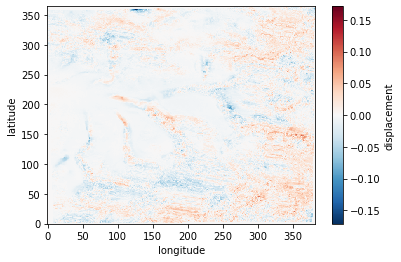

In [8]:
# Already in wgs84, just has no coordinates
disp_df.isel(date=7).displacement.plot.imshow()

In [9]:
# use the 'date' data variable to create date list
date_list = []
for i in disp_df['dstring']:
    date_list.append(dt.datetime.strptime(str(i)[40:48], '%Y%m%d'))

In [13]:
# function to rewrite coordinates from metadata
def coord_range(df, coord):
    if coord == 'lat' or coord == 'latitude':
        latrange = np.linspace(float(df.attrs['Y_FIRST']),((float(df.attrs['Y_STEP'])*float(df.attrs['LENGTH']))+float(df.attrs['Y_FIRST'])),int(df.attrs['LENGTH']))
        return latrange
    elif coord == 'lon' or coord == 'longitude':
        lonrange = np.linspace(float(df.attrs['X_FIRST']),((float(df.attrs['X_STEP'])*float(df.attrs['WIDTH']))+float(df.attrs['X_FIRST'])),int(df.attrs['WIDTH']))
        return lonrange

In [14]:
# rebuild coordinates
disp_df = disp_df.assign_coords({'date': ('date', np.array(date_list)),
                                 'latitude': ('latitude', coord_range(disp_df, 'lat')),
                                 'longitude': ('longitude', coord_range(disp_df, 'lon'))})

In [15]:
# Examine object
disp_df

<xarray.Dataset>
Dimensions:       (date: 69, latitude: 365, longitude: 382)
Coordinates:
  * date          (date) datetime64[ns] 2020-01-08 2020-01-20 ... 2022-04-27
  * latitude      (latitude) float64 3.095e+06 3.095e+06 ... 3.08e+06 3.08e+06
  * longitude     (longitude) float64 4.845e+05 4.845e+05 ... 4.998e+05
Data variables:
    bperp         (date) float32 0.0 -36.92 -51.09 ... -52.27 1.093 -23.68
    dstring       (date) |S8 b'20200108' b'20200120' ... b'20220415' b'20220427'
    displacement  (date, latitude, longitude) float32 ...
Attributes: (12/72)
    ALOOKS:                                    2
    ANTENNA_SIDE:                              -1
    AZIMUTH_PIXEL_SIZE:                        28.2
    BANDS:                                     1
    CENTER_LINE_UTC:                           44024.917845
    DATA_TYPE:                                 float32
    ...                                        ...
    mintpy.networkInversion.obsDatasetName:    unwrapPhase
    mintpy.networkInversion.weightFunc:        var
    mintpy.topographicResidual.excludeDate:    ['exclude_date.txt']
    mintpy.topographicResidual.phaseVelocity:  False
    mintpy.topographicResidual.polyOrder:      2
    mintpy.topographicResidual.stepFuncDate:   []

In [12]:
# set correct CRS
disp_df = disp_df.rio.write_crs(4326)
disp_df.rio.crs

CRS.from_epsg(4326)

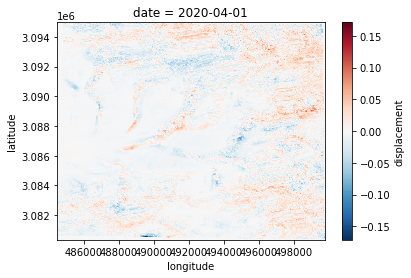

In [16]:
# Sanity check
disp_df.isel(date=7).displacement.plot.imshow()

In [14]:
# Probably not much use reprojecting to utm in this case. The site is small and within a degree of the equator. 

## Load in average velocity

In [17]:
# load in average velocity
vel_fn = '/tmp/mintpy/velocity.h5'
vel_df = xr.open_dataset(vel_fn, engine='h5netcdf', phony_dims='sort', decode_coords="all")

In [18]:
#examine structure
vel_df

<xarray.Dataset>
Dimensions:      (phony_dim_0: 365, phony_dim_1: 382)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables:
    velocity     (phony_dim_0, phony_dim_1) float32 ...
    velocityStd  (phony_dim_0, phony_dim_1) float32 ...
Attributes: (12/78)
    ALOOKS:                                    2
    ANTENNA_SIDE:                              -1
    AZIMUTH_PIXEL_SIZE:                        28.2
    BANDS:                                     1
    CENTER_LINE_UTC:                           44024.917845
    DATA_TYPE:                                 float32
    ...                                        ...
    mintpy.topographicResidual.stepFuncDate:   []
    mintpy.velocity.bootstrap:                 False
    mintpy.velocity.bootstrapCount:            400
    mintpy.velocity.endDate:                   20220427
    mintpy.velocity.excludeDate:               []
    mintpy.velocity.startDate:                 20200108

In [19]:
# rebuild dataset
vel_df = vel_df.rename_dims({'phony_dim_0':'latitude',
                             'phony_dim_1':'longitude'})

vel_df = vel_df.assign_coords({'latitude': ('latitude', coord_range(vel_df, 'lat')), 
                               'longitude': ('longitude', coord_range(vel_df, 'lon'))})

vel_df = vel_df.rio.write_crs(4326)
vel_df

<xarray.Dataset>
Dimensions:      (latitude: 365, longitude: 382)
Coordinates:
  * latitude     (latitude) float64 3.095e+06 3.095e+06 ... 3.08e+06 3.08e+06
  * longitude    (longitude) float64 4.845e+05 4.845e+05 ... 4.997e+05 4.998e+05
    spatial_ref  int64 0
Data variables:
    velocity     (latitude, longitude) float32 ...
    velocityStd  (latitude, longitude) float32 ...
Attributes: (12/78)
    ALOOKS:                                    2
    ANTENNA_SIDE:                              -1
    AZIMUTH_PIXEL_SIZE:                        28.2
    BANDS:                                     1
    CENTER_LINE_UTC:                           44024.917845
    DATA_TYPE:                                 float32
    ...                                        ...
    mintpy.topographicResidual.stepFuncDate:   []
    mintpy.velocity.bootstrap:                 False
    mintpy.velocity.bootstrapCount:            400
    mintpy.velocity.endDate:                   20220427
    mintpy.velocity.excludeDate:               []
    mintpy.velocity.startDate:                 20200108

## Load in polygons

In [18]:
# load json of aoi 
aoi_fn = '/tmp/polygons/crater.geojson'
aoi_gdf = gpd.read_file(aoi_fn)

In [19]:
# load json of stable reference areas
ref_fn = '/tmp/polygons/stable.geojson'
ref_gdf = gpd.read_file(ref_fn)

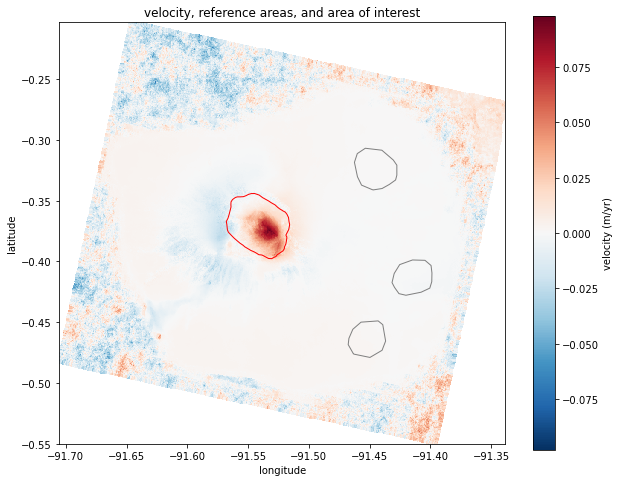

In [20]:
# Sanity check
f, ax = plt.subplots(figsize=(10,8))
vel_df.velocity.plot(ax=ax, cbar_kwargs={'label':'velocity (m/yr)'})
aoi_gdf.plot(ax=ax, facecolor='none', edgecolor='r')
ref_gdf.plot(ax=ax,  facecolor='none', edgecolor='gray')
ax.set_title('velocity, reference areas, and area of interest');

## Displacement of aoi and reference areas

In [21]:
# clip to aoi, clip to reference areas
disp_aoi = disp_df.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)
disp_ref = disp_df.rio.clip(ref_gdf.geometry, crs=ref_gdf.crs, drop=False)

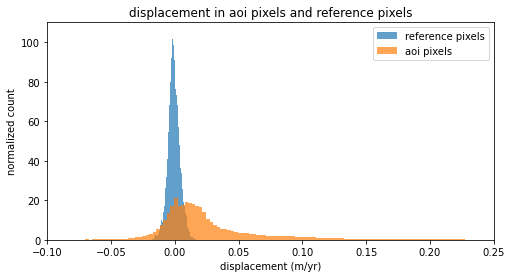

In [22]:
# Look at displacement distribution in aoi and reference area
f,ax = plt.subplots(figsize=(8,4))
ax.hist(np.ravel(disp_ref.displacement), bins=200, density=True, alpha=0.7, label='reference pixels')
ax.hist(np.ravel(disp_aoi.displacement), bins=200, density=True, alpha=0.7, label='aoi pixels')
ax.set_title('displacement in aoi pixels and reference pixels')
ax.set_ylabel('normalized count')
ax.set_xlabel('displacement (m/yr)')
ax.set_ylim(0,110)
ax.set_xlim(-0.1,0.25)
ax.legend();

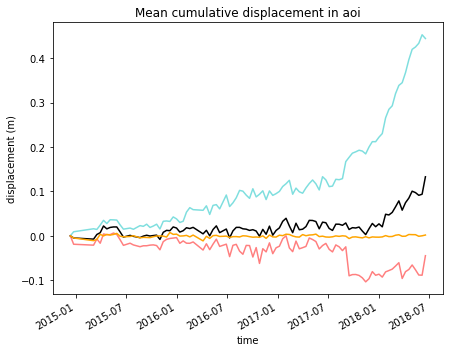

In [23]:
# look at cumulative displacement in aoi and reference area
f, ax = plt.subplots(figsize=(7,5))
disp_aoi.median(dim=('latitude', 'longitude')).displacement.plot(ax=ax, label='median', c='k')
disp_aoi.max(dim=('latitude', 'longitude')).displacement.plot(ax=ax, label='max', c='c', alpha=0.5)
disp_aoi.min(dim=('latitude', 'longitude')).displacement.plot(ax=ax, label='min', c='r', alpha=0.5)
disp_ref.median(dim=('latitude', 'longitude')).displacement.plot(ax=ax, label='median uncertainty', c='orange')
ax.set_title('Mean cumulative displacement in aoi')
ax.set_ylabel('displacement (m)')
ax.set_xlabel('time');

## Mean velocity of aoi and reference areas

In [24]:
# clip to aoi extent, clip to reference area extent
vel_aoi = vel_df.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)
vel_ref = vel_df.rio.clip(ref_gdf.geometry, crs=ref_gdf.crs, drop=False)

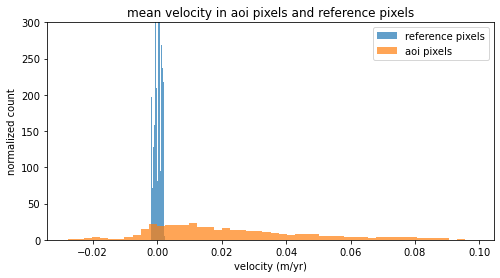

In [25]:
# look at velocity distribution in aoi and reference area
f,ax = plt.subplots(figsize=(8,4))
ax.hist(np.ravel(vel_ref.velocity), bins=50, density=True, alpha=0.7, label='reference pixels')
ax.hist(np.ravel(vel_aoi.velocity), bins=50, density=True, alpha=0.7, label='aoi pixels')
ax.set_title('mean velocity in aoi pixels and reference pixels')
ax.set_ylabel('normalized count')
ax.set_xlabel('velocity (m/yr)')
ax.set_ylim(0,300)
ax.legend();

In [26]:
# make 1d and remove na for plotting
aoi_filt = np.ravel(vel_aoi.velocity)[~np.isnan(np.ravel(vel_aoi.velocity))]
ref_filt = np.ravel(vel_ref.velocity)[~np.isnan(np.ravel(vel_ref.velocity))]

Text(0, 0.5, 'velocity (m/yr)')

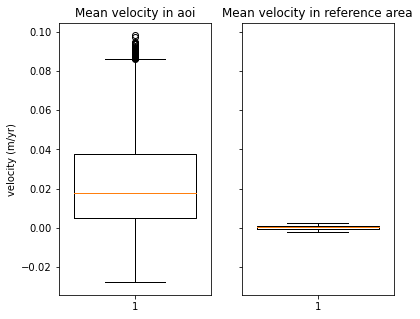

In [27]:
## Mean velocity in aoi and reference area
f, ax = plt.subplots(1, 2, figsize=(6,5), sharey=True)
ax[0].boxplot(aoi_filt, widths=0.8)
ax[1].boxplot(ref_filt, widths=0.8)
ax[0].set_title('Mean velocity in aoi')
ax[1].set_title('Mean velocity in reference area')
ax[0].set_ylabel('velocity (m/yr)')

## Change reference points 

In [28]:
# function to find value of new reference point in each time slice and subtract it from data array
rref_list = []

def change_ref(xarray, lat, lon):
    reref = xarray.copy(deep=True)
    for i in range(xarray.sizes['date']):
        # get value from grid
        rref_list.append(float(xarray.isel(date=i).displacement.sel(longitude=lon, latitude=lat, method="nearest").values))
    reref['displacement'] = disp_df['displacement'] - xr.DataArray(rref_list, dims='date')
    return reref       

In [29]:
#Sanity check: reference point in highly degforming area
disp_rref = change_ref(disp_df, -0.38, -91.525)

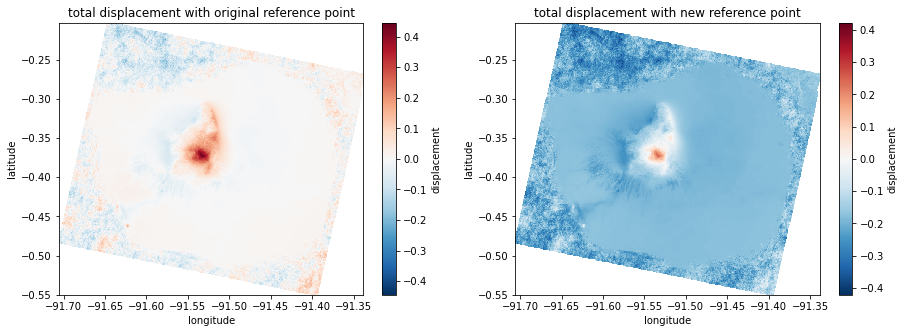

In [30]:
# Sanity check: plot cumulative displacement at new and old reference points
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
disp_df.isel(date=97)['displacement'].plot.imshow(ax=ax[0])
ax[0].set_title('total displacement with original reference point')

disp_rref.isel(date=97).displacement.plot.imshow(ax=ax[1])
ax[1].set_title('total displacement with new reference point');